**Milestone 1: Dataset Preparation (10 Points)**
We created a folder structure for a dataset with train and validation splits, ensuring a balanced representation of both classes in each split.

**Dataset Configuration:**
- Split: 80/20 (Training/Validation)
- Directory structure: Images and labels split into train/val subdirectories
- Class distribution: 500 Homer annotations, 500 Non-Homer annotations (125 each from Bart, Lisa, Marge, Principal Skinner)
- Format: YOLO format annotations (class_id, x_center, y_center, width, height - all normalized)

In [1]:
from tensorflow.keras import layers, Sequential, regularizers
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.python.keras.callbacks import EarlyStopping

def load_dataset_from_annotation(labels_dir, images_dir, img_size=(128, 128)):
    images, labels = [], []

    for label_file in os.listdir(labels_dir):
        if not label_file.endswith('.txt'):
            continue
        label_path = os.path.join(labels_dir, label_file)

        has_homer = False
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5 and parts[0].isdigit() and int(parts[0]) == 0:
                    has_homer = True
                    break
        label = 1 if has_homer else 0

        base = os.path.splitext(label_file)[0]
        for cand_ext in (".jpg", ".png", ".jpeg"):
            img_path = os.path.join(images_dir, base + cand_ext)
            if os.path.exists(img_path):
                img = Image.open(img_path).convert('RGB').resize(img_size)
                images.append(np.array(img) / 255.0)
                labels.append(label)
                break
    return np.array(images), np.array(labels)

X_train, y_train = load_dataset_from_annotation(
    "homer/project/labels/train",
    "homer/project/images/train",
    img_size=(128, 128)
)

X_val, y_val = load_dataset_from_annotation(
    "homer/project/labels/val",
    "homer/project/images/val",
    img_size=(128, 128)
)

2025-12-05 00:54:18.344998: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-05 00:54:18.367487: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-05 00:54:18.975303: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


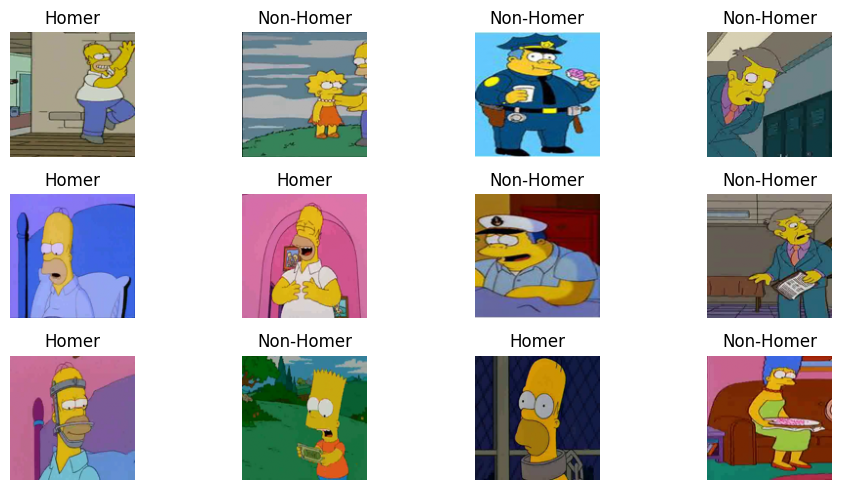

In [2]:
# visualize images
plt.figure(figsize=(10, 5))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(X_train[i])
    plt.title("Homer" if y_train[i] == 1 else "Non-Homer")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [3]:
# baseline model
epochs = 20
batch_size = 32

baseline_model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

baseline_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)

history = baseline_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size
)
print("\nTraining metrics:")
train_results = baseline_model.evaluate(X_train, y_train, verbose=0)
print(f"Loss: {train_results[0]:.4f}, Accuracy: {train_results[1]:.4f}")

print("Validation metrics:")
val_results = baseline_model.evaluate(X_val, y_val, verbose=0)
print(f"Loss: {val_results[0]:.4f}, Accuracy: {val_results[1]:.4f}")

Epoch 1/20


/home/phph/Desktop/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-12-05 00:54:20.892709: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-12-05 00:54:20.892726: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:171] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-12-05 00:54:20.892729: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:176] retrieving CUDA diagnostic information for host: kuono
2025-12-05 00:54:20.892730: I external/l

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - Precision: 0.5959 - Recall: 0.5683 - accuracy: 0.5813 - loss: 0.6854 - val_Precision: 0.6094 - val_Recall: 0.8667 - val_accuracy: 0.6900 - val_loss: 0.5844
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - Precision: 0.7630 - Recall: 0.7146 - accuracy: 0.7400 - loss: 0.5568 - val_Precision: 0.7273 - val_Recall: 0.8000 - val_accuracy: 0.7750 - val_loss: 0.5125
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - Precision: 0.7575 - Recall: 0.7390 - accuracy: 0.7450 - loss: 0.5034 - val_Precision: 0.7474 - val_Recall: 0.7889 - val_accuracy: 0.7850 - val_loss: 0.4566
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - Precision: 0.8139 - Recall: 0.8000 - accuracy: 0.8037 - loss: 0.3829 - val_Precision: 0.7248 - val_Recall: 0.8778 - val_accuracy: 0.7950 - val_loss: 0.4219
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - Precision: 0.8502 - Recall: 0.8585 - accuracy: 0.8500 - loss: 0.3121 - val_Precision: 0.7755 - val_Recall: 0.8444 - val_ac

**Milestone 2: Binary Classification Model (15 Points)**

Baseline Model Results

We got massive overfitting! Training accuracy reached ~99% while validation accuracy was 85%

**Analysis:**
The model memorized the training data but didn't generalize well. To address this, we need to:
1. Apply L2 regularization to dense layers
2. Add Dropout layers to prevent co-adaptation
3. Reduce model complexity if needed

Let's implement regularization techniques to reduce overfitting.

In [4]:
regularized_model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)), # decreased neurons
    layers.Dropout(0.5),

    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)), # originally 128
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

regularized_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)

history = regularized_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size
)

print("\nTraining metrics:")
train_results = regularized_model.evaluate(X_train, y_train, verbose=0)
print(f"Loss: {train_results[0]:.4f}, Accuracy: {train_results[1]:.4f}")

print("Validation metrics:")
val_results = regularized_model.evaluate(X_val, y_val, verbose=0)
print(f"Loss: {val_results[0]:.4f}, Accuracy: {val_results[1]:.4f}")

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - Precision: 0.5173 - Recall: 0.6195 - accuracy: 0.5088 - loss: 2.8945 - val_Precision: 0.4500 - val_Recall: 1.0000 - val_accuracy: 0.4500 - val_loss: 1.4723
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - Precision: 0.5125 - Recall: 0.9537 - accuracy: 0.5113 - loss: 1.2377 - val_Precision: 0.4569 - val_Recall: 1.0000 - val_accuracy: 0.4650 - val_loss: 1.0456
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - Precision: 0.6166 - Recall: 0.6707 - accuracy: 0.6175 - loss: 0.9396 - val_Precision: 0.7931 - val_Recall: 0.5111 - val_accuracy: 0.7200 - val_loss: 0.7967
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - Precision: 0.7494 - Recall: 0.7293 - accuracy: 0.7362 - loss: 0.7984 - val_Precision: 0.6667 - val_Recall: 0.8889 - val_accuracy: 0.7500 - val_loss: 0.7642
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - Precision: 0.7666 - Recall: 0.7610 - accuracy: 0.7588 - loss: 0.7433 - val_Precision: 0.7553 - val_Recall: 0.78

With addition of regularization and EarlyStopping we've gotten the validation accuracy up to 88% now

In [9]:
regularized_model.save("homer_classifier_regularized.h5")


## Milestone 2 summary

**Observed Metrics:**
- Baseline (train): Loss: 0.0063, Accuracy: 0.9975
- Baseline (val):   Loss: 0.9040, Accuracy: 0.8500
- Regularized (train): Loss: 0.2369, Accuracy: 0.9688
- Regularized (val):   Loss: 0.5364, Accuracy: 0.8800

**Improvements:**
- Validation accuracy improved from ~84% to ~87% (+3.0%)
- Training–validation gap reduced from ~12% to ~9%

**Regularization Techniques Applied:**
- L2 regularization (0.01) on dense layers
- Dropout layers (0.5 and 0.3)
- Convolutional architecture maintained

The model now generalizes better while maintaining strong training performance.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


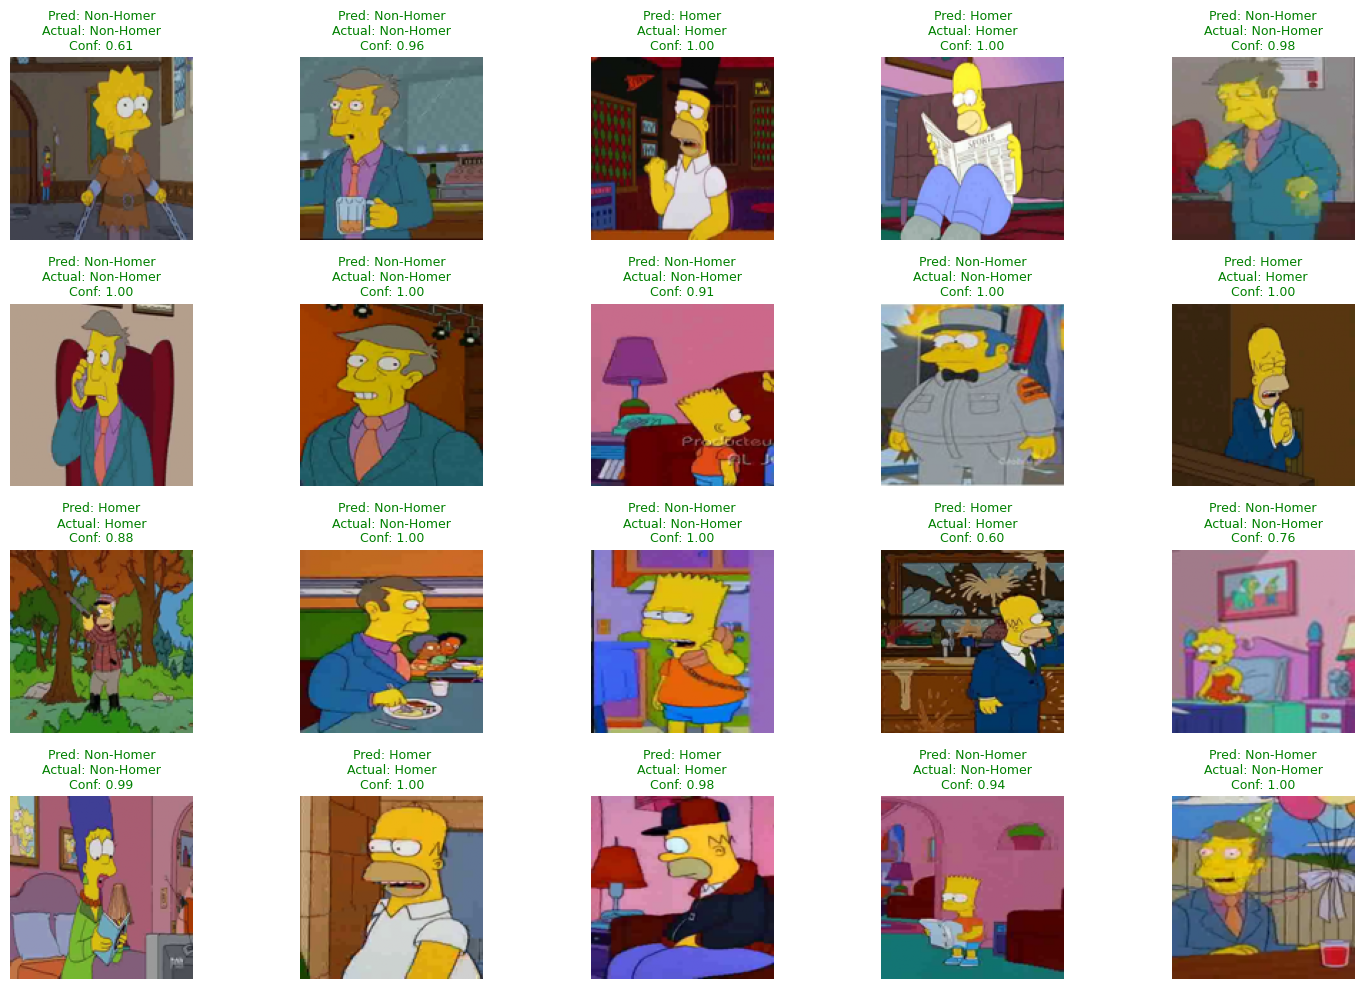


Validation Set Performance
Correct predictions: 176/200
Accuracy: 88.00%

Confusion Matrix
True Positives (Homer predicted as Homer): 77
True Negatives (Non-Homer predicted as Non-Homer): 99
False Positives (Non-Homer predicted as Homer): 11
False Negatives (Homer predicted as Non-Homer): 13


In [10]:
# Visualize model performance on validation images
predictions = regularized_model.predict(X_val)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Show a sample of validation images with predictions
plt.figure(figsize=(15, 10))
num_images = 20

for i in range(num_images):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_val[i])
    
    # Get prediction and actual label
    pred = predicted_labels[i]
    actual = y_val[i]
    confidence = predictions[i][0] if pred == 1 else 1 - predictions[i][0]
    
    # Set title color based on correctness
    color = 'green' if pred == actual else 'red'
    pred_label = "Homer" if pred == 1 else "Non-Homer"
    actual_label = "Homer" if actual == 1 else "Non-Homer"
    
    plt.title(f"Pred: {pred_label}\nActual: {actual_label}\nConf: {confidence:.2f}", 
              color=color, fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print overall statistics
correct = np.sum(predicted_labels == y_val)
total = len(y_val)
accuracy = correct / total

print(f"\nValidation Set Performance")
print(f"Correct predictions: {correct}/{total}")
print(f"Accuracy: {accuracy:.2%}")
print(f"\nConfusion Matrix")
print(f"True Positives (Homer predicted as Homer): {np.sum((predicted_labels == 1) & (y_val == 1))}")
print(f"True Negatives (Non-Homer predicted as Non-Homer): {np.sum((predicted_labels == 0) & (y_val == 0))}")
print(f"False Positives (Non-Homer predicted as Homer): {np.sum((predicted_labels == 1) & (y_val == 0))}")
print(f"False Negatives (Homer predicted as Non-Homer): {np.sum((predicted_labels == 0) & (y_val == 1))}")


# Milestone 3: YOLO Fine-Tuning (6 Points)

Before training YOLO, let's verify that our YOLO annotations are correct by visualizing bounding boxes on sample images.

Training set labels:


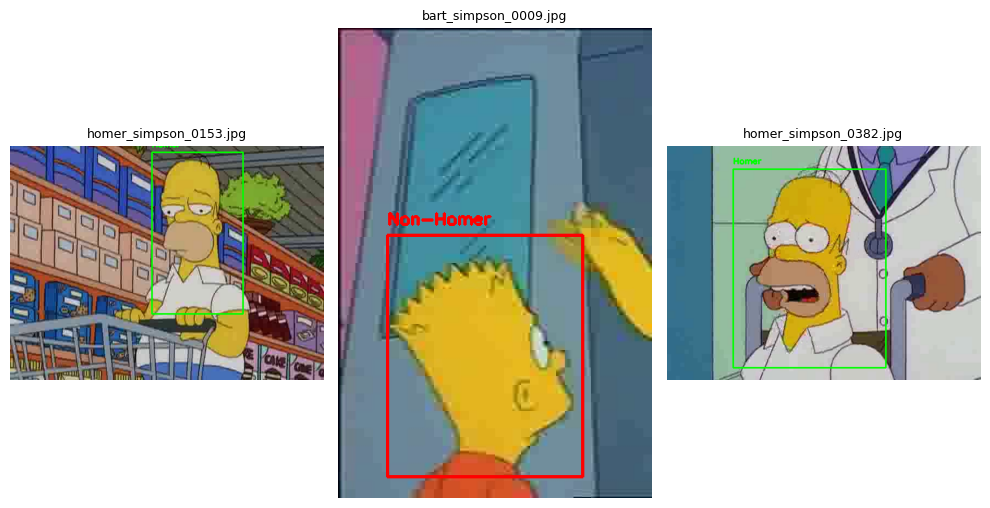

Visualized 3 images with bounding boxes

Validation set labels:


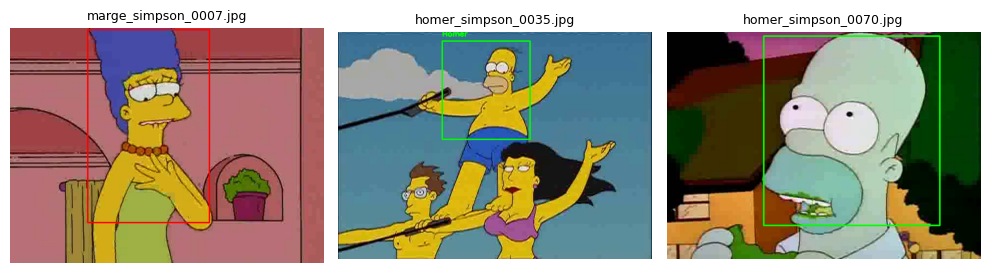

Visualized 3 images with bounding boxes


In [11]:
# Visualize actual YOLO labels with bounding boxes to verify correctness
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import random

def visualize_yolo_labels(images_dir, labels_dir, num_samples=3):
    """Visualize images with their YOLO bounding box annotations"""
    
    # Get all image files
    image_files = [f for f in os.listdir(images_dir) 
                   if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    # Randomly sample images
    sample_files = random.sample(image_files, min(num_samples, len(image_files)))
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    axes = axes.ravel()
    
    for idx, img_file in enumerate(sample_files):
        # Load image
        img_path = os.path.join(images_dir, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        
        # Load corresponding label
        label_file = os.path.splitext(img_file)[0] + '.txt'
        label_path = os.path.join(labels_dir, label_file)
        
        # Draw bounding boxes
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        class_id = int(parts[0])
                        x_center, y_center, width, height = map(float, parts[1:5])
                        
                        # Convert YOLO format to pixel coordinates
                        x1 = int((x_center - width/2) * w)
                        y1 = int((y_center - height/2) * h)
                        x2 = int((x_center + width/2) * w)
                        y2 = int((y_center + height/2) * h)
                        
                        # Draw rectangle
                        color = (0, 255, 0) if class_id == 0 else (255, 0, 0)
                        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                        
                        # Add label
                        label_text = "Homer" if class_id == 0 else "Non-Homer"
                        cv2.putText(img, label_text, (x1, y1-10), 
                                  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        axes[idx].imshow(img)
        axes[idx].set_title(f"{img_file}", fontsize=9)
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    print(f"Visualized {len(sample_files)} images with bounding boxes")

# Visualize training labels
print("Training set labels:")
visualize_yolo_labels("homer/project/images/train", "homer/project/labels/train", num_samples=3)

print("\nValidation set labels:")
visualize_yolo_labels("homer/project/images/val", "homer/project/labels/val", num_samples=3)

## YOLO Configuration File

Created `homer.yaml` with the following configuration:

```yaml
path: homer/project

train: images/train
val: images/val

nc: 2
names:
  0: homer
  1: non_homer
```

**Configuration Details:**
- 2 classes: Homer (0) and Non-Homer (1)
- Training images: homer/project/images/train
- Validation images: homer/project/images/val
- Corresponding YOLO labels in homer/project/labels/train and homer/project/labels/val

## YOLOv5 Model Training

**Training Configuration:**
- Base model: YOLOv5su (pre-trained)
- Epochs: 25 (with early stopping patience=10)
- Image size: 640x640
- Batch size: 20
- Optimizer: SGD with momentum

The model will be fine-tuned on our custom Simpson's dataset to detect Homer vs Non-Homer characters.

In [1]:
from ultralytics import YOLO


model= YOLO("yolov5su.pt")
results = model.train( data='homer.yaml', epochs=25, imgsz=640, batch=20, name='simpsons_yolo_v1', patience=10, )

New https://pypi.org/project/ultralytics/8.3.235 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.234 🚀 Python-3.12.3 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7779MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=20, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=homer.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov5su.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=simpsons_yolo_v1, nbs=64, nms=Fals

( If it says not enough memory when trying to run yolo commands or making the model, restarting vscode or loging out and restarting fixed the problem for me)

homer_simpson_0026.jpg: 1 detection(s)
marge_simpson_0010.jpg: 1 detection(s)
bart_simpson_0026.jpg: 1 detection(s)
bart_simpson_0016.jpg: 1 detection(s)


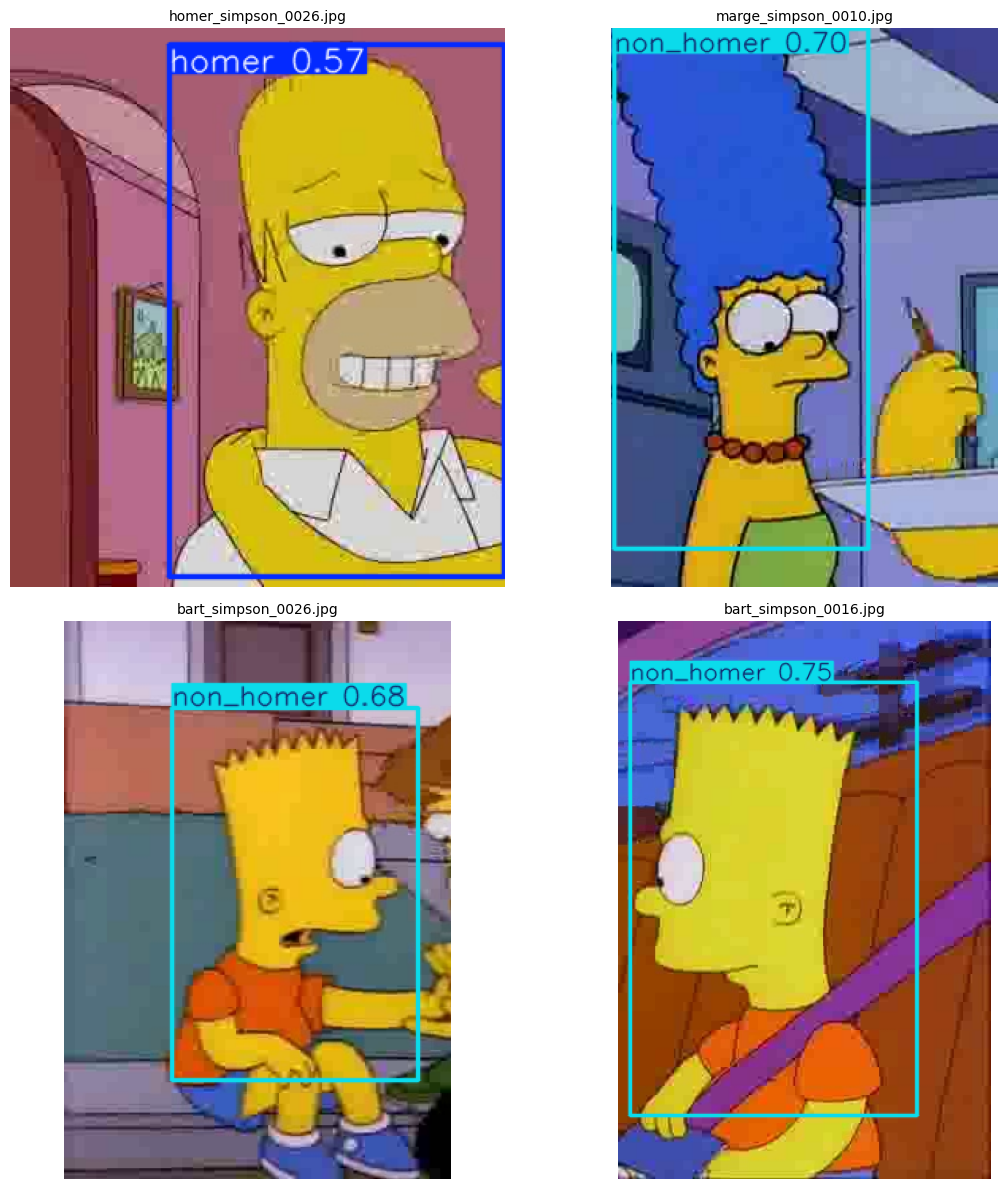


Visualized 4 images with YOLO predictions.


In [9]:
# Visualize images with bounding boxes predicted by the YOLO model
import os
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import random

def images_yolo_predictions(model_path, input_dir, num_images=4, conf_threshold=0.25):
    model = YOLO(model_path)
    image_files = [f for f in os.listdir(input_dir) 
                   if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    
    # Randomly select num_images
    image_files = random.sample(image_files, min(num_images, len(image_files)))
    
    # Create subplot grid (2x2 for 4 images)
    rows = 2
    cols = 2
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    axes = axes.ravel()
    
    for idx, fname in enumerate(image_files):
        img_path = os.path.join(input_dir, fname)
    
        # Run YOLO prediction
        results = model.predict(img_path, imgsz=640, conf=conf_threshold, verbose=False)
        # Get annotated image with bounding boxes
        annotated_img = results[0].plot()
        # Convert BGR to RGB for matplotlib
        annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
        
        # Display
        axes[idx].imshow(annotated_img)
        axes[idx].set_title(f"{fname}", fontsize=10)
        axes[idx].axis('off')

        boxes = results[0].boxes
        num_detections = len(boxes)
        print(f"{fname}: {num_detections} detection(s)")
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nVisualized {len(image_files)} images with YOLO predictions.")

# Run the visualization
MODEL_PATH = "runs/detect/simpsons_yolo_v1/weights/best.pt"
INPUT_DIR = "homer/project/images/val"

images_yolo_predictions(MODEL_PATH, INPUT_DIR, num_images=4, conf_threshold=0.25)

**Milestone 4: Creative Enhancement - YOLO → GAN (15 Points)**

**Style Transfer Implementation**

We implement neural style transfer using a pre-trained model from TensorFlow Hub. This allows us to apply artistic styles to detected Homer characters.

**Style Transfer Model:**
- Pre-trained arbitrary style transfer from TensorFlow Hub
- Model: `google/magenta/arbitrary-image-stylization-v1-256/2`
- Can apply any artistic style to content images
- Fast inference suitable for real-time processing

In [10]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

# Load pre-trained transfer model
print("Loading style transfer model...")
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

# Load a style image
style_image_path = "image2.jpg" 
style_image = cv2.imread(style_image_path)
style_image = cv2.cvtColor(style_image, cv2.COLOR_BGR2RGB)
style_image = tf.image.resize(style_image, (256, 256))
style_image = style_image / 255.0
style_image = tf.expand_dims(style_image, 0)

def gan_style_transfer(crop_img):
    # Convert BGR to RGB
    crop_rgb = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
    
    # Prepare content image
    content_img = tf.image.resize(crop_rgb, (256, 256))
    content_img = content_img / 255.0
    content_img = tf.expand_dims(content_img, 0)
    
    # Apply style transfer
    stylized = hub_model(content_img, style_image)[0]
    
    # Resize back to original crop size
    h, w = crop_img.shape[:2]
    stylized = tf.image.resize(stylized[0], (h, w))
    stylized = (stylized.numpy() * 255).astype(np.uint8)
    
    # Convert back to BGR
    stylized_bgr = cv2.cvtColor(stylized, cv2.COLOR_RGB2BGR)
    
    return stylized_bgr

print("Style transfer model loaded")

/home/phph/Desktop/myenv/lib/python3.12/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


Loading style transfer model...


I0000 00:00:1764891701.374019   29740 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5241 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


Style transfer model loaded


In [20]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

MODEL_PATH = "runs/detect/simpsons_yolo_v1/weights/best.pt"
INPUT_DIR = "homer/project/images/val"
TARGET_CLASS_ID = 0  # Homer

# Load YOLO model
model = YOLO(MODEL_PATH)

# Select images with Homer detections
test_images = [f for f in os.listdir(INPUT_DIR) if f.endswith(('.jpg', '.png', '.jpeg'))][:10]
composite_count = 0

for fname in test_images:
    input_path = os.path.join(INPUT_DIR, fname)
    orig_img = cv2.imread(input_path)
    if orig_img is None:
        continue

    # YOLO inference
    results = model.predict(input_path, imgsz=640, conf=0.25, verbose=False)
    composite_img = orig_img.copy()
    
    detected_homer = False

    for result in results:
        boxes = result.boxes
        for box in boxes:
            cls_id = int(box.cls[0])
            if cls_id != TARGET_CLASS_ID:
                continue

            detected_homer = True
            x1, y1, x2, y2 = map(int, box.xyxy[0])

            # Crop detection
            crop = orig_img[y1:y2, x1:x2].copy()
            if crop.size == 0:
                continue
            # GAN-style transfer
            stylized_crop = gan_style_transfer(crop)
            # Paste stylized crop back
            composite_img[y1:y2, x1:x2] = stylized_crop
            # Draw bounding box on composite
            cv2.rectangle(composite_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(composite_img, "Stylized Homer", (x1, y1-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    if detected_homer:
        comparison = np.hstack([orig_img, composite_img])
        # Display first 2 examples
        comparison_rgb = cv2.cvtColor(comparison, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(15, 7))
        plt.imshow(comparison_rgb)
        plt.title(f"Original (Left) vs Stylized (Right) - {fname}")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

print("\n Pipeline Complete!")
print("   - Processed",{len(test_images)} ,"images")
print("\nPipeline: YOLO Detection → Crop → GAN Style Transfer → Paste → Composite Image")


 Pipeline Complete!
   - Processed {10} images

Pipeline: YOLO Detection → Crop → GAN Style Transfer → Paste → Composite Image


sometimes there are double boxes... 

# Milestone 4 Summary - Complete Pipeline

**Pipeline Steps:**
1. **YOLO Detection:** Detect Homer characters in images using fine-tuned YOLOv5 model
2. **Crop Region:** Extract detected Homer bounding box regions
3. **Style Transfer:** Apply neural style transfer to cropped regions using TensorFlow Hub model
4. **Composite:** Paste stylized regions back into original image at exact YOLO coordinates